# iPython Profiler

IPython provides access to a wide range of functions to measure times and create profiles. The following magic IPython commands are explained here:

| Command        | Description                                                                       |
| -------------- | --------------------------------------------------------------------------------- |
| `%time`        | Time to execute a single statement                                                |
| `%timeit`      | Average time it took to execute a single statement repeatedly                     |
| `%prun`        | Run code with the profiler                                                        |
| `%lprun`       | Run code with the line-by-line profiler                                           |
| `%memit`       | Measure the memory usage of a single statement                                    |
| `%mprun`       | Executes the code with the line-by-line memory profiler                           |

The last four commands are not contained in IPython itself, but in the modules [line_profiler](https://github.com/pyutils/line_profiler) and [memory_profiler](https://github.com/pythonprofilers/memory_profiler).

## `%timeit` and `%time`

We saw the `%timeit` line and `%%timeit` cell magic in the introduction of the magic functions in IPython magic commands. They can be used to measure the timing of the repeated execution of code snippets:

In [1]:
%timeit sum(range(100))

1.59 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Note that `%timeit` executes the execution multiple times in a loop. If the number of loops is not specified with `-n`, `%timeit` automatically adjusts the number so that sufficient measurement accuracy is achieved:

In [2]:
%%timeit
total = 0
for i in range(1000):
    for j in range(1000):
        total += i * (-1) ** j

484 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Sometimes repeating an operation is not the best option, e.g. when we have a list that we want to sort. Here we may be misled by repeated surgery. Sorting a presorted list is much faster than sorting an unsorted list, so repeating it distorts the result:

In [3]:
import random
L = [random.random() for i in range(100000)]
%timeit L.sort()

942 µs ± 373 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Then the `%time` function might be a better choice. `%time` should also be the better choice for long-running commands, when short system-related delays are unlikely to affect the result:

In [4]:
import random
L = [random.random() for i in range(100000)]
%time L.sort()

CPU times: user 46 ms, sys: 0 ns, total: 46 ms
Wall time: 46.1 ms


Sorting an already sorted list:

In [5]:
%time L.sort ()

CPU times: user 1.99 ms, sys: 0 ns, total: 1.99 ms
Wall time: 2.01 ms


Note how much faster the pre-sorted list is to be sorted, but also note how much longer the timing with `%time` takes compared to `%timeit`, even for the pre-sorted list. This is due to the fact that `%timeit` is doing some clever things to keep system calls from interfering with the timing. This prevents, for example, the garbage collection of Python objects that are no longer used and that could otherwise affect the time measurement. Because of this, the `%timeit` results are usually noticeably faster than the `%time` results.

## Profiling for scripts: `%prun`

A program is made up of many individual instructions, and sometimes it is more important to measure those instructions in context than to measure them yourself. Python includes a built-in [Code-Profiler](https://docs.python.org/3/library/profile.html). However, IPython offers a much more convenient way to use this profiler in the form of the magic function `%prun`.

As an example, let’s define a simple function that does some calculations:

In [6]:
def sum_of_lists(N):
    total = 0
    for i in range(5):
        L = [j ^ (j >> i) for j in range(N)]
        total += sum(L)
    return total

In [7]:
%prun sum_of_lists(1000000)

In the notebook the output looks something like this:

```
14 function calls in 9.597 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        5    8.121    1.624    8.121    1.624 <ipython-input-15-f105717832a2>:4(<listcomp>)
        5    0.747    0.149    0.747    0.149 {built-in method builtins.sum}
        1    0.665    0.665    9.533    9.533 <ipython-input-15-f105717832a2>:1(sum_of_lists)
        1    0.065    0.065    9.597    9.597 <string>:1(<module>)
        1    0.000    0.000    9.597    9.597 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
```

The result is a table that shows the execution time for each function call, sorted by total time. In this case, most of the time is consumed with list comprehension within `sum_of_lists`. This gives us clues as to where we could improve the efficiency of the algorithm.

## Profiling line by line: `%lprun`

Profiling with `%prun` is useful, but sometimes a line-by-line profile report is more insightful. This isn’t built into Python or IPython, but there is a package available, [line_profiler](https://github.com/rkern/line_profiler), that enables this. This can be provided in your kernel with

```
$ spack env activate python-374
$ spack install py-line-profiler ^python@3.7.4%gcc@9.1.0
```

Alternatively, you can install `line-profiler` with other package managers, e.g.

```
$ pipenv install line_profiler
```

If you are using Python 3.7.x and get the error message `error: command 'clang' failed with exit status 1`, the only thing left for now is to install Cython together with the resources from the Git repository:

```
$ pipenv install Cython git+https://github.com/rkern/line_profiler.git#egg=line_profiler
```

Now you can load IPython with the `line_profiler` extension:

In [8]:
%load_ext line_profiler

The `%lprun` command profiles each function line by line. In this case, you must explicitly specify which functions are of interest for creating the profile:

In [9]:
%lprun -f sum_of_lists sum_of_lists(5000)

The result looks something like this:

```
Timer unit: 1e-06 s

Total time: 0.015145 s
File: <ipython-input-6-f105717832a2>
Function: sum_of_lists at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def sum_of_lists(N):
     2         1          1.0      1.0      0.0      total = 0
     3         6         11.0      1.8      0.1      for i in range(5):
     4         5      14804.0   2960.8     97.7          L = [j ^ (j >> i) for j in range(N)]
     5         5        329.0     65.8      2.2          total += sum(L)
     6         1          0.0      0.0      0.0      return total
```

The time is given in microseconds and we can see which line the function spends most of its time on. We may then be able to modify the script in such a way that the efficiency of the function can be increased.

More information about `%lprun` and the available options can be found in the IPython help function `%lprun?`.

## Create a storage profile:  `%memit` and `%mprun`

Another aspect of profiling is the amount of memory that an operation uses. This can be evaluated with another IPython extension, the `memory_profiler`. This can be provided in your kernel with

```
$ spack env activate python-374
$ spack install py-memory-profiler ^python@3.7.4%gcc@9.1.0
```

Alternatively you can install `memory-profiler` with other package managers, e.g.

```
$ pipenv install memory_profiler
```

In [10]:
%load_ext memory_profiler

In [11]:
%memit sum_of_lists(1000000)

peak memory: 138.18 MiB, increment: 71.01 MiB


We see that this feature occupies approximately 100 MB of memory.

For a line-by-line description of memory usage, we can use the `%mprun` magic. Unfortunately, this magic only works for functions that are defined in separate modules and not for the notebook itself. So we first use the `%%file` magic to create a simple module called `mprun_demo.py` that contains our `sum_of_lists` function.

In [12]:
%%file mprun_demo.py
from memory_profiler import profile
  
@profile
def my_func():
    a = [1] * (10 ** 6)
    b = [2] * (2 * 10 ** 7)
    del b
    return a

Overwriting mprun_demo.py


In [13]:
from mprun_demo import my_func
%mprun -f my_func my_func()

Filename: /srv/jupyter/jupyter-tutorial/docs/performance/mprun_demo.py

Line #    Mem usage    Increment   Line Contents
     3     67.5 MiB     67.5 MiB   @profile
     4                             def my_func():
     5     75.1 MiB      7.6 MiB       a = [1] * (10 ** 6)
     6    227.5 MiB    152.4 MiB       b = [2] * (2 * 10 ** 7)
     7     75.2 MiB      0.0 MiB       del b
     8     75.2 MiB      0.0 MiB       return a





Here the `Increment` column shows how much each row affects the total memory consumption: Note that when we calculate `b` we need about 160 MB of additional memory; however, this is not released again by deleting `b`.

More information about `%memit`, `%mprun` and their options can be found in the IPython help with `%memit?`.

## pyheatmagic

[pyheatmagic](https://github.com/csurfer/pyheatmagic) is an extension that allows the IPython magic command `%%heat` to display Python code as a heatmap with [Py-Heat](https://github.com/csurfer/pyheat).

It can be easily installed in the kernel with

```
$ pipenv install py-heat-magic
Installing py-heat-magic…
…```

### Loading the extension in IPython

In [14]:
%load_ext heat

### Display the heat map

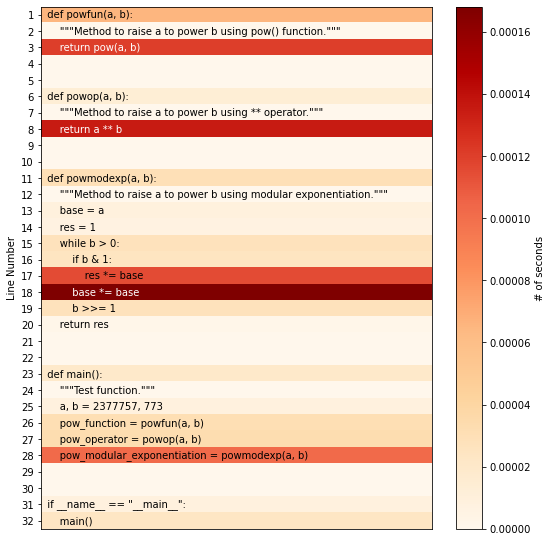

In [15]:
%%heat
def powfun(a, b):
    """Method to raise a to power b using pow() function."""
    return pow(a, b)


def powop(a, b):
    """Method to raise a to power b using ** operator."""
    return a ** b


def powmodexp(a, b):
    """Method to raise a to power b using modular exponentiation."""
    base = a
    res = 1
    while b > 0:
        if b & 1:
            res *= base
        base *= base
        b >>= 1
    return res


def main():
    """Test function."""
    a, b = 2377757, 773
    pow_function = powfun(a, b)
    pow_operator = powop(a, b)
    pow_modular_exponentiation = powmodexp(a, b)


if __name__ == "__main__":
    main()


Alternatively, the heatmap can also be saved as a file, e.g. with

```
%%heat -o pow-heatmap.png
```

## See also:

* [Penn Machine Learning Benchmarks](https://github.com/EpistasisLab/pmlb)